# Project: Fundamentals of Information Systems 

### Introduction

This data has been gathered at **two solar power plants** in India over a **34 day** period. It has **two** pairs of files - each pair has **one power generation dataset** and **one sensor readings dataset**. 
- The **power generation datasets** are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. 
- The **sensor data** is gathered at a plant level - a single array of sensors optimally placed at the plant.

### Output

**Questions.**
- What is the **mean** value of **daily yield**? 
- What is the **total irradiation per day**? 
- What is the **max ambient** and **module temperature**? 
- **How many inverters** are there **for each plant**? 
- What is the **maximum/minimum amount** of **DC/AC Power generated** in a **time interval/day**? 
- **Which inverter** (source_key) has produced **maximum DC/AC power**? 
- **Rank the inverters** based on the **DC/AC power** they produce? Is there **any missing data**?


- Graphs that explain the patterns for attributes independent of other variables. These will usually be tracked as changes of attributes against DATETIME, DATE, or TIME. 

**Examples.** How is DC or AC Power changing as time goes by? how is irradiation changing as time goes by? how are ambient and module temperature changing as time goes by? how does yield change as time goes by? Explore plotting variables against different granularities of DATETIME and which is the best option for each variable.

### Variables

##### Power generation data
- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
 
- PLANT_ID: Plant ID - this will be common for the entire file.

- SOURCE_KEY: Source key in this file stands for the inverter id.

- DC_POWER: Amount of DC power **(corrente continua)** generated by the inverter (source_key) in this 15 minute interval. Units - kW.

- AC_POWER: Amount of AC power **(corrente alternata)** generated by the inverter (source_key) in this 15 minute interval. Units - kW.

- DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time.

- TOTAL_YIELD: This is the total yield for the inverter till that point in time.

##### Weather sensor data
- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.

- PLANT_ID: Plant ID - this will be common for the entire file.

- SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.

- AMBIENT_TEMPERATURE: This is the ambient temperature at the plant.

- MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.

- IRRADIATION: Amount of irradiation for the 15 minute interval.

###################################################################################################################

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import seaborn as sns

### Data

In [2]:
p1_gen = pd.read_csv('Plant_1_Generation_Data.csv')
p1_wea = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
p2_gen = pd.read_csv('Plant_2_Generation_Data.csv')
p2_wea = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

### Fill NaN dataset [p1_gen]

Ho scritto un ciclo che cambia la **SOURCE_KEY** del dataset iniziale molto complessa in una più semplice da leggere e trattare. 

In [3]:
d1_gen = {}
for i,j in enumerate(set(p1_gen['SOURCE_KEY'])):
    d1_gen[j] = 's' + str(i) + '_gen1'
p1_gen['SOURCE_KEY'] = p1_gen['SOURCE_KEY'].replace(d1_gen)
print(d1_gen)

{'WRmjgnKYAwPKWDb': 's0_gen1', 'ZnxXDlPa8U1GXgE': 's1_gen1', 'pkci93gMrogZuBj': 's2_gen1', 'VHMLBKoKgIrUVDU': 's3_gen1', 'YxYtjZvoooNbGkE': 's4_gen1', '1IF53ai7Xc0U56Y': 's5_gen1', 'iCRJl6heRkivqQ3': 's6_gen1', 'McdE0feGgRqW7Ca': 's7_gen1', 'ih0vzX44oOqAx2f': 's8_gen1', 'bvBOhCH3iADSZry': 's9_gen1', 'uHbuxQJl8lW7ozc': 's10_gen1', '1BY6WEcLGh8j5v7': 's11_gen1', 'zVJPv84UY57bAof': 's12_gen1', 'sjndEbLyjtCKgGv': 's13_gen1', 'adLQvlD726eNBSB': 's14_gen1', 'rGa61gmuvPhdLxV': 's15_gen1', 'wCURE6d3bPkepu2': 's16_gen1', 'z9Y9gH1T5YWrNuG': 's17_gen1', '3PZuoBAID5Wc2HD': 's18_gen1', 'ZoEaEvLYb1n2sOq': 's19_gen1', 'zBIq5rxdHJRwDNY': 's20_gen1', '7JYdWkrLSPkdwr4': 's21_gen1'}


In [4]:
p1_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,s11_gen1,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,s5_gen1,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,s18_gen1,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,s21_gen1,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,s7_gen1,0.0,0.0,0.0,7158964.0


Questa funzione riceve in input una **SOURCE_KEY** (per la prima tabella **p1_gen**) e restituisce in output il dataset relativo alla stessa **SOURCE_KEY** in cui sono state inserite le date mancanti. I valori mancanti vengono identificati con il valore "NaN". Per semplicità la colonna **DATE_TIME** viene divisa in colonna **DATE** e colonna **TIME**, come richiesto in una parte dei quesiti del progetto.

In [5]:
def fill_na_dataset(s):
    init = datetime.datetime(year = 2020, month = 5, day = 15, hour = 0, minute = 0)
    finit = datetime.datetime(year = 2020, month = 6, day = 18, hour = 0, minute = 0)
    new_DATE_TIME = np.arange(init, finit, datetime.timedelta(minutes = 15)).astype(datetime.datetime)
    new_DATE_TIME = pd.DataFrame([i.strftime('%d-%m-%Y %H:%M') for i in new_DATE_TIME], columns = ['DATE_TIME'])
    p1_s = p1_gen.loc[p1_gen['SOURCE_KEY'] == s]
    p1_s = pd.merge(p1_s, new_DATE_TIME, on = 'DATE_TIME', how = 'right')
    date = []; time = []
    for i in p1_s['DATE_TIME']:
        date.append(re.split(' ', i)[0])
        time.append(re.split(' ', i)[1])
    p1_s['DATE'] = date
    p1_s['TIME'] = time
    p1_s.drop(['DATE_TIME'], axis = 1)
    p1_s = p1_s[['DATE', 'TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
    p1_s['DATE'] = pd.to_datetime(p1_s['DATE'], format = '%d-%m-%Y')
    p1_s.sort_values(['DATE', 'TIME'], inplace = True)
    p1_s.loc[p1_s['SOURCE_KEY'].isna() == True, 'SOURCE_KEY'] = s
    return p1_s

In [6]:
s0_gen1 = fill_na_dataset('s0_gen1')
s1_gen1 = fill_na_dataset('s1_gen1')
s2_gen1 =fill_na_dataset('s2_gen1')
s3_gen1 = fill_na_dataset('s3_gen1')
s4_gen1 = fill_na_dataset('s4_gen1')
s5_gen1 = fill_na_dataset('s5_gen1')
s6_gen1 = fill_na_dataset('s6_gen1')
s7_gen1 = fill_na_dataset('s7_gen1')
s8_gen1 = fill_na_dataset('s8_gen1')
s9_gen1 = fill_na_dataset('s9_gen1')
s10_gen1 = fill_na_dataset('s10_gen1')
s11_gen1 = fill_na_dataset('s11_gen1')
s12_gen1 = fill_na_dataset('s12_gen1')
s13_gen1 = fill_na_dataset('s13_gen1')
s14_gen1 = fill_na_dataset('s14_gen1')
s15_gen1 = fill_na_dataset('s15_gen1')
s16_gen1 = fill_na_dataset('s16_gen1')
s17_gen1 = fill_na_dataset('s17_gen1')
s18_gen1 = fill_na_dataset('s18_gen1')
s19_gen1 = fill_na_dataset('s19_gen1')
s20_gen1 = fill_na_dataset('s20_gen1')
s21_gen1 = fill_na_dataset('s21_gen1')

In [7]:
subdataset_gen1 = [s0_gen1, s1_gen1, s2_gen1, s3_gen1, s4_gen1, s5_gen1, 
              s6_gen1, s7_gen1, s8_gen1, s9_gen1, s10_gen1, s11_gen1, 
              s12_gen1, s13_gen1, s14_gen1, s15_gen1, s16_gen1, s17_gen1, 
              s18_gen1, s19_gen1, s20_gen1, s21_gen1]
new_p1_gen = pd.concat(subdataset_gen1, ignore_index = True)

In [8]:
new_p1_gen.head()

,DATE,TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,00:00,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
1,2020-05-15,00:15,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
2,2020-05-15,00:30,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
3,2020-05-15,00:45,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
4,2020-05-15,01:00,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0


### Fill NaN dataset [p2_gen]

Tutto ciò che è stato fatto per la **gen_1** viene ripetuto in maniera uguale anche per la **gen_2**. Essendo le **SOURCE_KEY** diverse nella **gen_2** il nome viene cambiato in maniera analoga a quanto vista prima. 

In [9]:
d2_gen = {}
for i,j in enumerate(set(p2_gen['SOURCE_KEY'])):
    d2_gen[j] = 's' + str(i) + '_gen2'
p2_gen['SOURCE_KEY'] = p2_gen['SOURCE_KEY'].replace(d2_gen)
print(d2_gen)

{'LYwnQax7tkwH5Cb': 's0_gen2', 'WcxssY2VbP4hApt': 's1_gen2', 'oZZkBaNadn6DNKz': 's2_gen2', '81aHJ1q11NBPMrL': 's3_gen2', '9kRcWv60rDACzjR': 's4_gen2', 'vOuJvMaM2sgwLmb': 's5_gen2', 'PeE6FRyGXUgsRhN': 's6_gen2', 'Mx2yZCDsyf6DPfv': 's7_gen2', 'Quc1TzYxW2pYoWX': 's8_gen2', '4UPUqMRk7TRMgml': 's9_gen2', 'LlT2YUhhzqhg5Sw': 's10_gen2', 'oZ35aAeoifZaQzV': 's11_gen2', 'xMbIugepa2P7lBB': 's12_gen2', 'q49J1IKaHRwDQnt': 's13_gen2', 'rrq4fwE8jgrTyWY': 's14_gen2', 'V94E5Ben1TlhnDV': 's15_gen2', 'xoJJ8DcxJEcupym': 's16_gen2', 'IQ2d7wF4YD8zU1Q': 's17_gen2', 'mqwcsP2rE7J0TFp': 's18_gen2', 'Et9kgGMDl729KT4': 's19_gen2', 'NgDl19wMapZy17u': 's20_gen2', 'Qf4GUc1pJu5T6c6': 's21_gen2'}


In [10]:
def fill_na_dataset2(s):
    init = datetime.datetime(year = 2020, month = 5, day = 15, hour = 0, minute = 0, second = 0)
    finit = datetime.datetime(year = 2020, month = 6, day = 18, hour = 0, minute = 0, second = 0)
    new_DATE_TIME = np.arange(init, finit, datetime.timedelta(minutes = 15)).astype(datetime.datetime)
    new_DATE_TIME = pd.DataFrame([i.strftime('%Y-%m-%d %H:%M:%S') for i in new_DATE_TIME], columns = ['DATE_TIME'])
    p2_s = p2_gen.loc[p2_gen['SOURCE_KEY'] == s]
    p2_s = pd.merge(p2_s, new_DATE_TIME, on = 'DATE_TIME', how = 'right')
    date = []; time = []
    for i in p2_s['DATE_TIME']:
        date.append(re.split(' ', i)[0])
        time.append(re.split(' ', i)[1])
    p2_s['DATE'] = date
    p2_s['TIME'] = time
    p2_s.drop(['DATE_TIME'], axis = 1)
    p2_s = p2_s[['DATE', 'TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
    p2_s['DATE'] = pd.to_datetime(p2_s['DATE'], format = '%Y-%m-%d')
    p2_s.sort_values(['DATE', 'TIME'], inplace = True)
    p2_s.loc[p2_s['SOURCE_KEY'].isna() == True, 'SOURCE_KEY'] = s
    return p2_s

In [11]:
s0_gen2 = fill_na_dataset2('s0_gen2')
s1_gen2 = fill_na_dataset2('s1_gen2')
s2_gen2 =fill_na_dataset2('s2_gen2')
s3_gen2 = fill_na_dataset2('s3_gen2')
s4_gen2 = fill_na_dataset2('s4_gen2')
s5_gen2 = fill_na_dataset2('s5_gen2')
s6_gen2 = fill_na_dataset2('s6_gen2')
s7_gen2 = fill_na_dataset2('s7_gen2')
s8_gen2 = fill_na_dataset2('s8_gen2')
s9_gen2 = fill_na_dataset2('s9_gen2')
s10_gen2 = fill_na_dataset2('s10_gen2')
s11_gen2 = fill_na_dataset2('s11_gen2')
s12_gen2 = fill_na_dataset2('s12_gen2')
s13_gen2 = fill_na_dataset2('s13_gen2')
s14_gen2 = fill_na_dataset2('s14_gen2')
s15_gen2 = fill_na_dataset2('s15_gen2')
s16_gen2 = fill_na_dataset2('s16_gen2')
s17_gen2 = fill_na_dataset2('s17_gen2')
s18_gen2 = fill_na_dataset2('s18_gen2')
s19_gen2 = fill_na_dataset2('s19_gen2')
s20_gen2 = fill_na_dataset2('s20_gen2')
s21_gen2 = fill_na_dataset2('s21_gen2')

In [12]:
subdataset_gen2 = [s0_gen2, s1_gen2, s2_gen2, s3_gen2, s4_gen2, s5_gen2, 
              s6_gen2, s7_gen2, s8_gen2, s9_gen2, s10_gen2, s11_gen2, 
              s12_gen2, s13_gen2, s14_gen2, s15_gen2, s16_gen2, s17_gen2, 
              s18_gen2, s19_gen2, s20_gen2, s21_gen2]
new_p2_gen = pd.concat(subdataset_gen2, ignore_index = True)

In [13]:
new_p2_gen.head()

,DATE,TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,00:00:00,4136001.0,s0_gen2,0.0,0.0,1872.5,1.794959e+09
1,2020-05-15,00:15:00,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
2,2020-05-15,00:30:00,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
3,2020-05-15,00:45:00,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
4,2020-05-15,01:00:00,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09


Sono stati ottenuti quindi i due dataset **new_p1_gen** e **new_p2_gen** che contengono il dataset riempito con valori "NaN" in corrispondenza delle date/orari mancanti. 

- N.B. Le uniche colonne != NaN sono **DATE, TIME** e **SOURCE_KEY** 

###################################################################################################################

Per comodità ho copiato e rinominato i dataset col nome precedente, cioè **p1_gen** e **p2_gen**. D'ora in avanti si utilizzeranno questi due ultimi dataset per effettuare le analisi. Ora verrà/verranno:
- riempita la colonna **PLANT_ID**;
- creata una nuova colonna che segnala se il valore era precedentemente mancante, in particolare:
    - se la data/orario erano già presenti nel dataset di partenza il valore sarà **0**;
    - se la data/orario erano assenti nel dataset di partenza il valore sarà **1**.
- sostituiti tutti i valori "NaN" rimanenti con 0, in particolare **DC_POWER, AC_POWER, DAILY YIELD, TOTAL YIELD**.
- creata una colonna addizionale denominata **DATE_TIME** in cui vengono aggregate **DATE** e **TIME**.

In [14]:
p1_gen = new_p1_gen.copy()
p2_gen = new_p2_gen.copy()
#####################################################################################
p1_gen.loc[p1_gen['PLANT_ID'].isna() == True, 'PLANT_ID'] = 4135001.0
p2_gen.loc[p2_gen['PLANT_ID'].isna() == True, 'PLANT_ID'] = 4136001.0
#####################################################################################
p1_gen['MISS_VAL'] = np.nan
p2_gen['MISS_VAL'] = np.nan
#####################################################################################
p1_gen.loc[p1_gen['DC_POWER'].isna() == True, 'MISS_VAL'] = 1
p1_gen.loc[p1_gen['DC_POWER'].isna() == False, 'MISS_VAL'] = 0
p2_gen.loc[p2_gen['DC_POWER'].isna() == True, 'MISS_VAL'] = 1
p2_gen.loc[p2_gen['DC_POWER'].isna() == False, 'MISS_VAL'] = 0
#####################################################################################
p1_gen.loc[p1_gen['DC_POWER'].isna() == True, 'DC_POWER':'TOTAL_YIELD'] = 0
p2_gen.loc[p2_gen['DC_POWER'].isna() == True, 'DC_POWER':'TOTAL_YIELD'] = 0
#####################################################################################
p1_gen['DATE_TIME'] = ''
p2_gen['DATE_TIME'] = ''
#####################################################################################
p1_gen['DATE_TIME'] = p1_gen['DATE'].astype(str) + ' ' + p1_gen['TIME'].astype(str)
p2_gen['DATE_TIME'] = p2_gen['DATE'].astype(str) + ' ' + p2_gen['TIME'].astype(str)
p1_gen = p1_gen[['DATE_TIME', 'DATE', 'TIME', 'MISS_VAL', 'PLANT_ID', 
                 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
p2_gen = p2_gen[['DATE_TIME', 'DATE', 'TIME', 'MISS_VAL', 'PLANT_ID', 
                 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
#####################################################################################
format_DATE_TIME = []; format_TIME = []
for i,j in zip(p2_gen.DATE_TIME, p2_gen.TIME):
    format_DATE_TIME.append(i[0:16])
    format_TIME.append(j[0:5])
p2_gen['DATE_TIME'] = format_DATE_TIME
p2_gen['TIME'] = format_TIME

In [15]:
p1_gen.head()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00,2020-05-15,00:00,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
1,2020-05-15 00:15,2020-05-15,00:15,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
2,2020-05-15 00:30,2020-05-15,00:30,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
3,2020-05-15 00:45,2020-05-15,00:45,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
4,2020-05-15 01:00,2020-05-15,01:00,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0


In [16]:
p2_gen.head()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00,2020-05-15,00:00,0.0,4136001.0,s0_gen2,0.0,0.0,1872.5,1.794959e+09
1,2020-05-15 00:15,2020-05-15,00:15,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
2,2020-05-15 00:30,2020-05-15,00:30,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
3,2020-05-15 00:45,2020-05-15,00:45,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
4,2020-05-15 01:00,2020-05-15,01:00,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09


###################################################################################################################

In [17]:
init = datetime.datetime(year = 2020, month = 5, day = 15, hour = 0, minute = 0, second = 0)
finit = datetime.datetime(year = 2020, month = 6, day = 18, hour = 0, minute = 0, second = 0)
new_DATE_TIME = np.arange(init, finit, datetime.timedelta(minutes = 15)).astype(datetime.datetime)
new_DATE_TIME = pd.DataFrame([i.strftime('%Y-%m-%d %H:%M:%S') for i in new_DATE_TIME], columns = ['DATE_TIME'])
p1_w = pd.merge(p1_wea, new_DATE_TIME, on = 'DATE_TIME', how = 'right')
p2_w = pd.merge(p2_wea, new_DATE_TIME, on = 'DATE_TIME', how = 'right')

In [18]:
date1 = []; time1 = []
date2 = []; time2 = []

for i in p1_w['DATE_TIME']:
    date1.append(re.split(' ', i)[0])
    time1.append(re.split(' ', i)[1])
p1_w['DATE'] = date1
p1_w['TIME'] = time1

for i in p2_w['DATE_TIME']:
    date2.append(re.split(' ', i)[0])
    time2.append(re.split(' ', i)[1])
p2_w['DATE'] = date2
p2_w['TIME'] = time2

In [19]:
p1_w = p1_w[['DATE_TIME', 'DATE', 'TIME', 'PLANT_ID', 'SOURCE_KEY', 
             'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
p2_w = p2_w[['DATE_TIME', 'DATE', 'TIME', 'PLANT_ID', 'SOURCE_KEY', 
             'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
p1_w = p1_w.drop(['DATE_TIME'], axis = 1)
p2_w = p2_w.drop(['DATE_TIME'], axis = 1)

In [20]:
p1_w.head()

,DATE,TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,00:15:00,4135001.0,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15,00:30:00,4135001.0,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15,00:45:00,4135001.0,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15,01:00:00,4135001.0,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [21]:
p2_w.head()

,DATE,TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,00:00:00,4136001.0,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15,00:15:00,4136001.0,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15,00:30:00,4136001.0,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15,00:45:00,4136001.0,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15,01:00:00,4136001.0,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [22]:
p1_w['DATE'] = pd.to_datetime(p1_w['DATE'], format = '%Y-%m-%d')
p2_w['DATE'] = pd.to_datetime(p2_w['DATE'], format = '%Y-%m-%d')
#####################################################################################
p1_w.sort_values(['DATE', 'TIME'], inplace = True)
p2_w.sort_values(['DATE', 'TIME'], inplace = True)
#####################################################################################
p1_wea = p1_w.copy()
p2_wea = p2_w.copy()
#####################################################################################
p1_wea.loc[p1_wea['PLANT_ID'].isna() == True, 'PLANT_ID'] = 4135001.0
p2_wea.loc[p2_wea['PLANT_ID'].isna() == True, 'PLANT_ID'] = 4136001.0
#####################################################################################
p1_wea['MISS_VAL'] = np.nan
p2_wea['MISS_VAL'] = np.nan
#####################################################################################
p1_wea.loc[p1_wea['AMBIENT_TEMPERATURE'].isna() == True, 'MISS_VAL'] = 1
p1_wea.loc[p1_wea['AMBIENT_TEMPERATURE'].isna() == False, 'MISS_VAL'] = 0
p2_wea.loc[p2_wea['AMBIENT_TEMPERATURE'].isna() == True, 'MISS_VAL'] = 1
p2_wea.loc[p2_wea['AMBIENT_TEMPERATURE'].isna() == False, 'MISS_VAL'] = 0
#####################################################################################
p1_wea.loc[p1_wea['AMBIENT_TEMPERATURE'].isna() == True, 'SOURCE_KEY'] = 'HmiyD2TTLFNqkNe'
p2_wea.loc[p2_wea['AMBIENT_TEMPERATURE'].isna() == True, 'SOURCE_KEY'] = 'iq8k7ZNt4Mwm3w0'
#####################################################################################
p1_wea.loc[p1_wea['AMBIENT_TEMPERATURE'].isna() == True, 'AMBIENT_TEMPERATURE':'IRRADIATION'] = 0
p2_wea.loc[p2_wea['AMBIENT_TEMPERATURE'].isna() == True, 'AMBIENT_TEMPERATURE':'IRRADIATION'] = 0
#####################################################################################
p1_wea['DATE_TIME'] = ''
p2_wea['DATE_TIME'] = ''
#####################################################################################
p1_wea['DATE_TIME'] = p1_wea['DATE'].astype(str) + ' ' + p1_wea['TIME'].astype(str)
p2_wea['DATE_TIME'] = p2_wea['DATE'].astype(str) + ' ' + p2_wea['TIME'].astype(str)
#####################################################################################
p1_wea = p1_wea[['DATE_TIME', 'DATE', 'TIME', 'MISS_VAL', 'PLANT_ID', 'SOURCE_KEY', 
                 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
p2_wea = p2_wea[['DATE_TIME', 'DATE', 'TIME', 'MISS_VAL', 'PLANT_ID', 'SOURCE_KEY', 
                 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

###################################################################################################################

Riassumendo sono stati ottenuti:

In [23]:
p1_gen.head()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00,2020-05-15,00:00,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
1,2020-05-15 00:15,2020-05-15,00:15,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
2,2020-05-15 00:30,2020-05-15,00:30,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
3,2020-05-15 00:45,2020-05-15,00:45,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0
4,2020-05-15 01:00,2020-05-15,01:00,0.0,4135001.0,s0_gen1,0.0,0.0,0.0,7028673.0


In [24]:
p2_gen.head()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00,2020-05-15,00:00,0.0,4136001.0,s0_gen2,0.0,0.0,1872.5,1.794959e+09
1,2020-05-15 00:15,2020-05-15,00:15,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
2,2020-05-15 00:30,2020-05-15,00:30,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
3,2020-05-15 00:45,2020-05-15,00:45,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09
4,2020-05-15 01:00,2020-05-15,01:00,0.0,4136001.0,s0_gen2,0.0,0.0,0.0,1.794959e+09


In [25]:
p1_wea.tail()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
3177,2020-06-17 22:45:00,2020-06-17,22:45:00,0.0,4135001.0,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,2020-06-17,23:00:00,0.0,4135001.0,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,2020-06-17,23:15:00,0.0,4135001.0,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,2020-06-17,23:30:00,0.0,4135001.0,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0
3181,2020-06-17 23:45:00,2020-06-17,23:45:00,0.0,4135001.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


In [26]:
p2_wea.head()

,DATE_TIME,DATE,TIME,MISS_VAL,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,2020-05-15,00:00:00,0.0,4136001.0,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,2020-05-15,00:15:00,0.0,4136001.0,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,2020-05-15,00:30:00,0.0,4136001.0,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,2020-05-15,00:45:00,0.0,4136001.0,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,2020-05-15,01:00:00,0.0,4136001.0,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


The next few steps are going to clean a pair of columns with a defective behavior reguarding the 2nd plant (p2_gen).  

In [28]:
#in this piece of code we are going to set a coherent amount of total yield to all the data
#in the case it is less than the day before it will be changed because is a cumulative value

limit = 3263 #limit is important to update upd
upd = 0   # upd controls the change between different panels in data
for value_taken in range(len(p2_gen)- 1):  #we take all the values
    ind = value_taken     #ind can be updated outside of the for
    if (ind - upd) % 3263 == 0.0:
        ind += 1       #if we are finishing a panel we skip compairing the first value of the new one with the last of old one
        #print(upd)
    if value_taken > (limit + upd):
        upd += 1   #update our indexes
        limit += 3263    
    if ind >= 71806:    #evitate out of bounds
        ind = 71805
    data1 = p2_gen.iloc[ind + 1]   #time + 1
    data2 = p2_gen.iloc[ind]       #time
    if data1.TOTAL_YIELD < data2.TOTAL_YIELD:    #if next value is less than previous
        p2_gen.loc[ind + 1, "TOTAL_YIELD"] = data2.TOTAL_YIELD    # set as previous

In [29]:
#in this piece of code we will clean the gen2 data that present the daily yield of the day before 
#on the night of the day after. This not reguards missing data.  

#note: it will take up to 3-4 minutes

def reset_night(value, source, dd):
    """
    resets the daily yield of night value
    this function needs the value of the daily yield at 00:00, the source key and the day is referring
    and will reset all the data of the night/morning if it hasn't reset the value of the day before jet
    """
    for ind in p2_gen.TIME.unique()[0:32]: #only morning time
        select = p2_gen.loc[(p2_gen.SOURCE_KEY == source) & (p2_gen.DATE == dd) & (p2_gen.TIME == ind)].DAILY_YIELD
        if select.item() > 250:    #not affecting the starting of the day
            if (select.item() - value).item() >= 0:  #if some morning data are taken new values are not affected
                p2_gen.loc[(p2_gen.SOURCE_KEY == source) & (p2_gen.DATE == dd) & (p2_gen.TIME == ind), "DAILY_YIELD"] = select - value
            else:    #no negative values
                p2_gen.loc[(p2_gen.SOURCE_KEY == source) & (p2_gen.DATE == dd) & (p2_gen.TIME == ind), "DAILY_YIELD"] = 0.0
            

for source in p2_gen.SOURCE_KEY.unique(): 
    for day in p2_gen.DATE.unique(): 
        reset_val = p2_gen[(p2_gen.DATE == day) & (p2_gen.TIME == "00:00") & (p2_gen.SOURCE_KEY == source)].DAILY_YIELD
        if reset_val.any() > 0:
            reset_night(reset_val, source, day)  

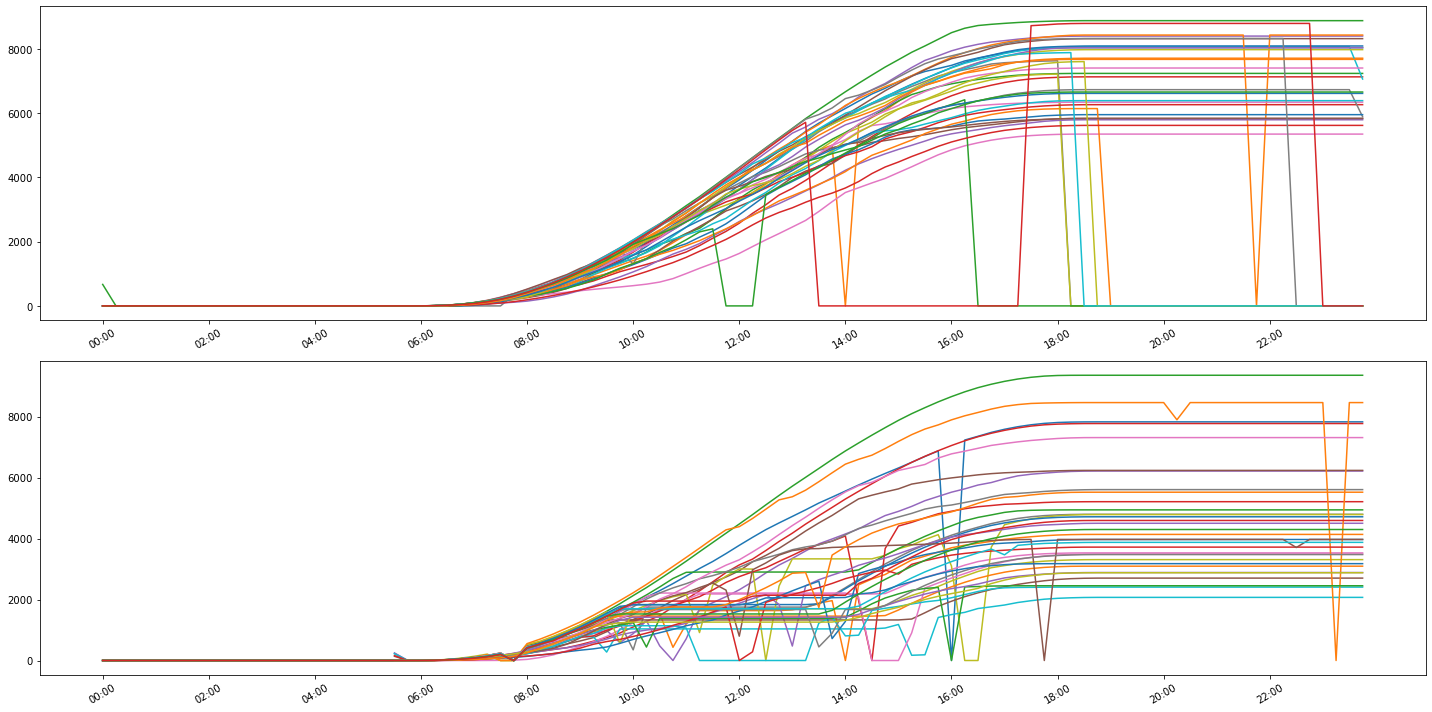

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for date in set(p1_gen.DATE):
    times = [str(time) for time in sorted(list(set(p1_gen.TIME)))]
    plt.plot(times,p1_gen[(p1_gen.SOURCE_KEY == p1_gen.SOURCE_KEY[0]) & (p1_gen.DATE == date)].DAILY_YIELD)
    plt.xticks(ticks=times[::8],rotation=30)
plt.subplot(2,1,2)
for date in set(p2_gen.DATE):
    times = [str(time) for time in sorted(list(set(p2_gen.TIME)))]
    plt.plot(times,p2_gen[(p2_gen.SOURCE_KEY == p2_gen.SOURCE_KEY[0]) & (p2_gen.DATE == date)].DAILY_YIELD)
    plt.xticks(ticks=times[::8],rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
#p1_gen.to_csv('Desktop/FIS project/NEW_Plant_1_Generation_Data.csv', header = True, index = False)
#p1_wea.to_csv('Desktop/FIS project/NEW_Plant_1_Weather_Sensor_Data.csv', header = True, index = False)
#p2_gen.to_csv('Desktop/FIS project/NEW_Plant_2_Generation_Data.csv', header = True, index = False)
#p2_wea.to_csv('Desktop/FIS project/NEW_Plant_2_Weather_Sensor_Data.csv', header = True, index = False

In the following section will be performed the calculation for obtaining a ranking of the various panels. There will be two rankings at the end. The first is the general one, the second does not count the data signed as missing values in the calculations, so is a little different. The general result is that the first plant of panels seems to be better than the second in the production of energy for the period in which data were collected.

Ranking is performed on AC/DC production over the days in mean and taking the mean of the maximums. 

In [31]:
#here will be created a dataframe with importantant values for each source key in order to make a ranking
def create_summit(data1):
    """
    this function returns a dataframe of key values for each source key in data1
    """
    uniq = data1.SOURCE_KEY.unique()
    tab1 = pd.DataFrame()
    source_keys = []
    dc_mean = []
    dc_max = []
    ac_mean = []
    ac_max = []
    
    for sou_key in uniq:
        panel = data1[data1.SOURCE_KEY == sou_key]
        source_keys.append(sou_key)
        dc_mean.append(panel.groupby("DATE").DC_POWER.mean().mean())
        dc_max.append(panel.groupby("DATE").DC_POWER.max().mean())
        ac_mean.append(panel.groupby("DATE").AC_POWER.mean().mean())
        ac_max.append(panel.groupby("DATE").AC_POWER.max().mean())
         
    tab1["SOURCE_KEY"] = np.array(source_keys)
    tab1["DC_MEAN"] = np.array(dc_mean)
    tab1["DC_MAX"] = np.array(dc_max)
    tab1["AC_MEAN"] = np.array(ac_mean)
    tab1["AC_MAX"] = np.array(ac_max)
    return tab1
        
summit =  pd.concat([create_summit(p1_gen), create_summit(p2_gen)], ignore_index=True)
summit.tail()

,SOURCE_KEY,DC_MEAN,DC_MAX,AC_MEAN,AC_MAX
39,s17_gen2,206.008468,902.047035,201.437677,880.218287
40,s18_gen2,198.920624,882.408244,194.529610,861.108170
41,s19_gen2,184.251241,951.975777,180.335695,930.265140
42,s20_gen2,197.348195,889.541701,192.992465,868.065122
43,s21_gen2,272.854266,1171.798053,266.775630,1143.528011


In [32]:
#this code calculates 4 different rankings based on the 4 different columns of the previous dataframe
rank1 = summit.sort_values("DC_MEAN", ascending= False)["SOURCE_KEY"]
rank1 = {rank1.iloc[i] : i for i in range(len(rank1))}
rank2 = summit.sort_values("DC_MAX", ascending= False)["SOURCE_KEY"]
rank2 = {rank2.iloc[i] : i for i in range(len(rank2))}
rank3 = summit.sort_values("AC_MEAN", ascending= False)["SOURCE_KEY"]
rank3 = {rank3.iloc[i] : i for i in range(len(rank3))}
rank4 = summit.sort_values("AC_MAX", ascending= False)["SOURCE_KEY"]
rank4 = {rank4.iloc[i] : i for i in range(len(rank4))}

In [33]:
#the final ranking is here reported with the score obtained as the sum of the position in each rank
ranking = {k: rank1.get(k) + rank2.get(k) + rank3.get(k) + rank4.get(k) for k in set(rank1)}
ranking = pd.DataFrame([ranking])
ranking.index.name = "SOURCE"
ranking.rename({0: 'SCORE'}, inplace=True)
ranking = ranking.T.sort_values("SCORE")
print("Best five of the final ranking with their score: ")
print(ranking.head())

Best five of the final ranking with their score: 
SOURCE    SCORE
s14_gen1      0
s3_gen1       8
s18_gen1      8
s5_gen1       8
s7_gen1      18


In [34]:
#this ranking will be performed only on those source without counting missing values (more distorted)
summit =  pd.concat([create_summit(p1_gen[p1_gen.MISS_VAL == 0.0]), 
                     create_summit(p2_gen[p2_gen.MISS_VAL == 0.0])], ignore_index=True)
rank1 = summit.sort_values("DC_MEAN", ascending= False)["SOURCE_KEY"]
rank1 = {rank1.iloc[i] : i for i in range(len(rank1))}
rank2 = summit.sort_values("DC_MAX", ascending= False)["SOURCE_KEY"]
rank2 = {rank2.iloc[i] : i for i in range(len(rank2))}
rank3 = summit.sort_values("AC_MEAN", ascending= False)["SOURCE_KEY"]
rank3 = {rank3.iloc[i] : i for i in range(len(rank3))}
rank4 = summit.sort_values("AC_MAX", ascending= False)["SOURCE_KEY"]
rank4 = {rank4.iloc[i] : i for i in range(len(rank4))}
ranking = {k: rank1.get(k) + rank2.get(k) + rank3.get(k) + rank4.get(k) for k in set(rank1)}
ranking = pd.DataFrame([ranking])
ranking.index.name = "SOURCE"
ranking.rename({0: 'SCORE'}, inplace=True)
ranking = ranking.T.sort_values("SCORE")
print("Best five of the final ranking with their score: (no missing values taken in the means calculation) ")
print(ranking.head())

Best five of the final ranking with their score: (no missing values taken in the means calculation) 
SOURCE    SCORE
s14_gen1      0
s18_gen1      6
s5_gen1       8
s3_gen1      10
s7_gen1      18


In [35]:
#here is retrieved the original code of the best panel
for index, value in d1_gen.items(): 
    if ranking.index[0] == value:
        print(f"The best panel is: {index}")    

The best panel is: adLQvlD726eNBSB
